# Comparison with buoys from the IABP

Due to the swift currents, buoys that enter the Greenland Sea through the Fram Strait tend to only briefly reside in the sea ice zone. We examined buoy trajectories from the International Arctic Buoy Program that travel through the study area (defined by the MODIS image extent) during April-September 2003-2020. 

In [1]:
import cartopy.crs as ccrs
import numpy as np
import pandas as pd
import pyproj
import rasterio as rio
import ultraplot as uplt

uplt.rc['geo.round'] = False
uplt.rc['reso'] = 'med'

ref_img = rio.open("../data/modis_images/landmask.tiff")
crs0 = pyproj.CRS('WGS84')
crs1 = pyproj.CRS(ref_img.crs)
transformer = pyproj.Transformer.from_crs(crs0, crs_to=crs1, always_xy=True)
left, bottom, right, top = ref_img.bounds

In [2]:
data_loc = '../data/iabp_miz_data/'
buoy_data = {}
for year in range(2003, 2021):
    df = pd.read_csv(data_loc + 'iabp_data_{y}.csv'.format(y=year),
                     index_col=0, parse_dates=['datetime'])
    df['x_stere'], df['y_stere'] = transformer.transform(df.longitude, df.latitude)
    start_date = pd.to_datetime('{y}-04-01'.format(y=year))
    end_date = pd.to_datetime('{y}-09-30'.format(y=year))
    in_scene = df.x_stere.between(left, right) & df.y_stere.between(bottom, top)
    in_timerange = df.datetime.between(start_date, end_date)
    sel_idx = in_scene & in_timerange
    df_counts = df.loc[sel_idx].groupby('buoy_id').count()
    if len(df_counts) > 0:
        if len(df.loc[sel_idx]) > 100:
            buoy_data[year] = df.loc[in_scene & in_timerange].copy()

In [ ]:
# Plot buoy tracks by year

In [3]:
print("Year", "Number", "Cumulative Number", "Data Points")
number_buoys = 0
for year in buoy_data:
    number_buoys += len(buoy_data[year].buoy_id.unique())
    print(year, len(buoy_data[year].buoy_id.unique()), number_buoys,  len(buoy_data[year]))

Year Number Cumulative Number Data Points
2005 1 1 439
2008 2 3 5988
2010 3 6 3708
2012 3 9 758
2013 1 10 2276
2014 8 18 13720
2015 18 36 16473
2016 2 38 5428
2017 13 51 10729
2018 4 55 4750
2019 12 67 7573
2020 99 166 176712


In [4]:
crs = ccrs.NorthPolarStereo(central_longitude=-45, true_scale_latitude=70)
for year in buoy_data:
    fig, axs = uplt.subplots(width=4, proj='npstere',
                             proj_kw={'lon_0': -45}, share=False)
    axs.format(land=True, lonlocator=np.arange(-100, 30, 10), latmax=85, latlocator=np.arange(55, 85, 5), latlabels=True, lonlabels=True)
    axs.set_extent([left, right, bottom, top], crs=crs)  
    for buoy_id, group in buoy_data[year].groupby('buoy_id'):
        axs.plot(group.longitude, group.latitude, c='k', lw=3, zorder=1)
        c = axs.scatter(group.longitude, group.latitude, c=group.sic_monthly * 100, 
               cmap='ice', vmin=0, vmax=1, marker='.', ms=5, zorder=2)
    axs.colorbar(c, label='Sea Ice Concentration (Monthly)')
    axs.format(ltitle=str(year), rtitle='Num. buoys = ' + str(len(buoy_data[year].buoy_id.unique())))
    fig.save('../figures/diagnostics/iabp_trajectories/iabp_trajectories_{y}.png'.format(y=year), dpi=300)
    uplt.close(fig)

# QC 
Basic manual QC, since there aren't very many buoys. For the MOSAiC year, we'll need to restrict the numbers.

In [5]:
import sys
sys.path.append('../scripts/')
from drifter import compute_velocity

In [6]:
buoy_data.keys()

dict_keys([2005, 2008, 2010, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020])

In [153]:
year = 2016
buoy_dfs = {buoy_id: group for buoy_id, group in buoy_data[year].groupby('buoy_id')}

In [154]:
print('Length: ', len(buoy_dfs.keys()))
for x in buoy_dfs.keys():
    print(x, buoy_dfs[x].datetime.max())

Length:  2
300234062553800 2016-08-15 13:00:00
300234062784540 2016-08-08 12:02:00


# Notes for 2020
This is the MOSAiC year, so there are lots of these that are included in the MOSAiC dataset. In particular we'll need to establish a buffer, even as small as 10 km could help, to separate out the buoys that are on the same floe as each other.

In [10]:
import os
mosaic_lookup = {}
mosaic_buoys = os.listdir('../../../../data/buoy_data/adc_dn_tracks/')
for m in mosaic_buoys:
    if '.csv' in m:
        if 'DN' not in m:
            if 'summary' not in m:
                site, imei, buoy_id = m.split("_")
                mosaic_lookup[imei] = [site, buoy_id.replace('.csv', '')]


In [11]:
print('Length: ', len(buoy_dfs.keys()))
for x in buoy_dfs.keys():
    if str(x) in mosaic_lookup:
        print(x, ' '.join(mosaic_lookup[str(x)]))
        # pass
    else:
        print(x)

Length:  99
53093
900094
900102
900111
900116
300025010644540 CO1 2020M29
300025010649550 CO2 2020M26
300025060102020 CO2 2020M27
300025060111910 L1 2019R8
300025060614630 L3 2020R12
300234010077180 P032 2019P143
300234010082440 P081 2020P210
300234010084660 P082 2020P211
300234010307830 P077 2020P213
300234011091780 P079 2020P215
300234011097770 P078 2020P214
300234062321110 CO1 2020E2
300234062429060
300234064233210 LM 2020E3
300234064817930 P064 2019T47
300234065090840 P026 2019P137
300234065091110 P034 2019P146
300234065091830 P024 2019P144
300234065094850 P035 2019P148
300234065170760 M3 2019T59
300234065171770
300234065171790 M4 2019T58
300234065716210
300234065762510
300234065980580 P013 2019P138
300234065980590 P025 2019P136
300234065981590 P008 2019P142
300234065984580 P021 2019P140
300234065985570 P022 2019P139
300234066082230 P062 2019P127
300234066083130 CO1 2020S97
300234066085220 P063 2019P128
300234066087170 L1 2020S99
300234066087220 P047 2019P125
300234066089220 P040 2

# Selecting MOSAiC buoys
1. Representative buoy for CO1. Single track until 2020-07-17, using the T buoy as reference (imei ending in 600). Other CO1 buoys chosen if they separate from the rest of the track, and we select just the subset after separation.
2. 


In [16]:
mosaic_lookup

{'300025060015720': ['L2', '2019R9'],
 '300234065981590': ['P008', '2019P142'],
 '300125060219720': ['L1', '2019W4'],
 '300234068706330': ['LM', '2019T66'],
 '300534061805870': ['P092', '2020P164'],
 '300025060111910': ['L1', '2019R8'],
 '300534061902360': ['P098', '2020P170'],
 '300234068915790': ['P019', '2019P203'],
 '300234067700680': ['P050', '2019P91'],
 '300534061905370': ['P104', '2020P176'],
 '300234068318250': ['P053', '2019P151'],
 '300534061902370': ['P099', '2020P171'],
 'ASFS50UCB': ['CO1', 'ASFS50UCB2'],
 '300534061800900': ['P090', '2020P162'],
 '300234068813870': ['P117', '2020P233'],
 '300234068166760': ['M4', '2019O4'],
 '300234061164580': ['P068', '2019P119'],
 '300234066083130': ['CO1', '2020S97'],
 '300234068704730': ['CO3', '2020T85'],
 '300234010077180': ['P032', '2019P143'],
 '300234067009210': ['M5', '2019S87'],
 '300234065090840': ['P026', '2019P137'],
 'ASFS30UCB': ['CO1', 'ASFS30UCB2'],
 '300534061801880': ['P091', '2020P163'],
 '300234068519770': ['M7', '2

In [12]:
co1_buoys = [int(b) for b in mosaic_lookup if (mosaic_lookup[b][0] == 'CO1') & ('ASF' not in b)]
co1_buoys = [b for b in co1_buoys if b in buoy_dfs]
co1_buoys

[300234066083130,
 300234068210310,
 300025010644540,
 300234068325170,
 300234062321110,
 300234068527600]

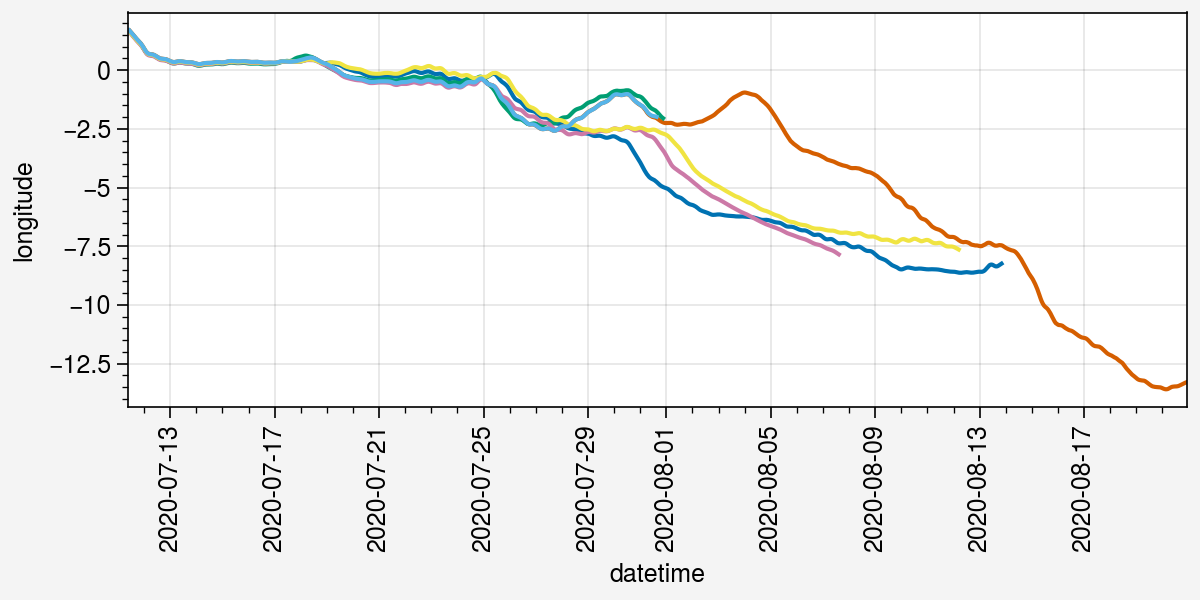

In [979]:
ts = slice('2020-07-11', '2020-08-20')
fig, ax = pplt.subplots(width=6, height=3)
for b in co1_buoys:
    LL = buoy_dfs[b].set_index('datetime').longitude.copy()
    LL[LL > 180] = LL[LL > 180] - 360
    ax.plot(LL.loc[ts])

In [934]:
lsite_buoys = [int(b) for b in mosaic_lookup if (mosaic_lookup[b][0][0] == 'L')  & ('ASF' not in b)]
lsite_buoys = [b for b in lsite_buoys if b in buoy_dfs]
lsite_buoys

[300234068706330,
 300025060111910,
 300234068705280,
 300234066087170,
 300234068709320,
 300234068706290,
 300234068705730,
 300234064233210,
 300025060614630]

NameError: name 'lsite_buoys' is not defined

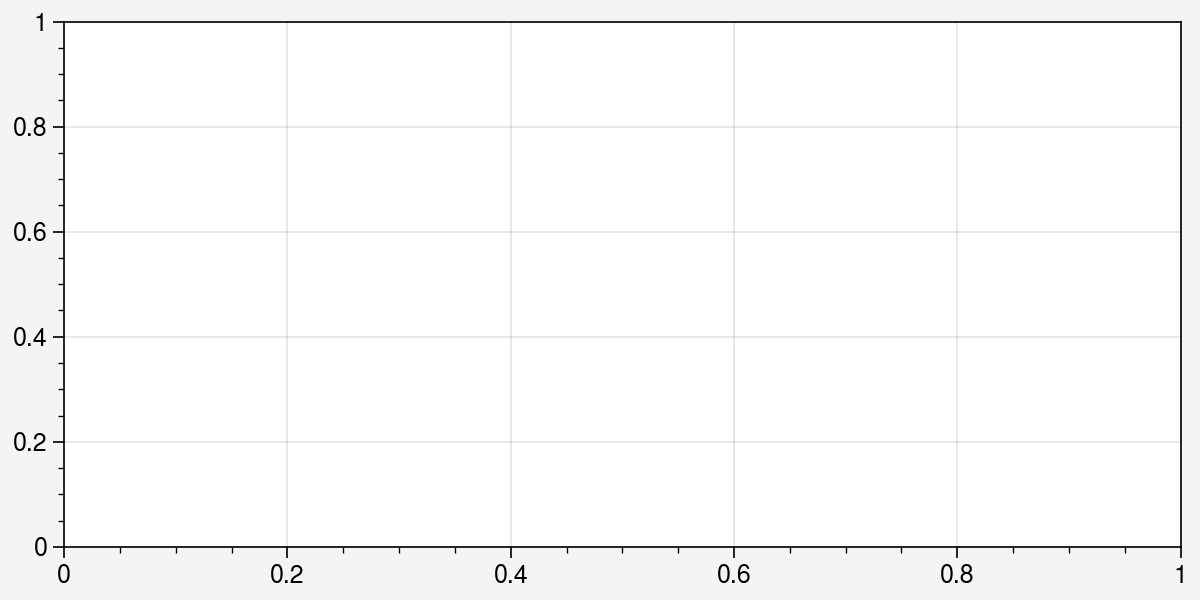

In [45]:
ts = slice('2020-07-01', '2020-09-20')
fig, ax = uplt.subplots(width=6, height=3)
for b in lsite_buoys:
    LL = buoy_dfs[b].set_index('datetime').longitude.copy()
    LL[LL > 180] = LL[LL > 180] - 360
    ax.plot(LL.loc[ts])
    ax.text(LL.index[-1], LL.values[-1], mosaic_lookup[str(b)][0])

In [46]:
msite_buoys = [int(b) for b in mosaic_lookup if (mosaic_lookup[b][0][0] == 'M')  & ('ASF' not in b)]
msite_buoys = [b for b in msite_buoys if b in buoy_dfs]
msite_buoys

[300234068166760,
 300234068164710,
 300234068066320,
 300234068514740,
 300234067066520,
 300234065170760,
 300234068700320,
 300234065171790,
 300234067064370,
 300234066995900,
 300234066444880,
 300234068701300]

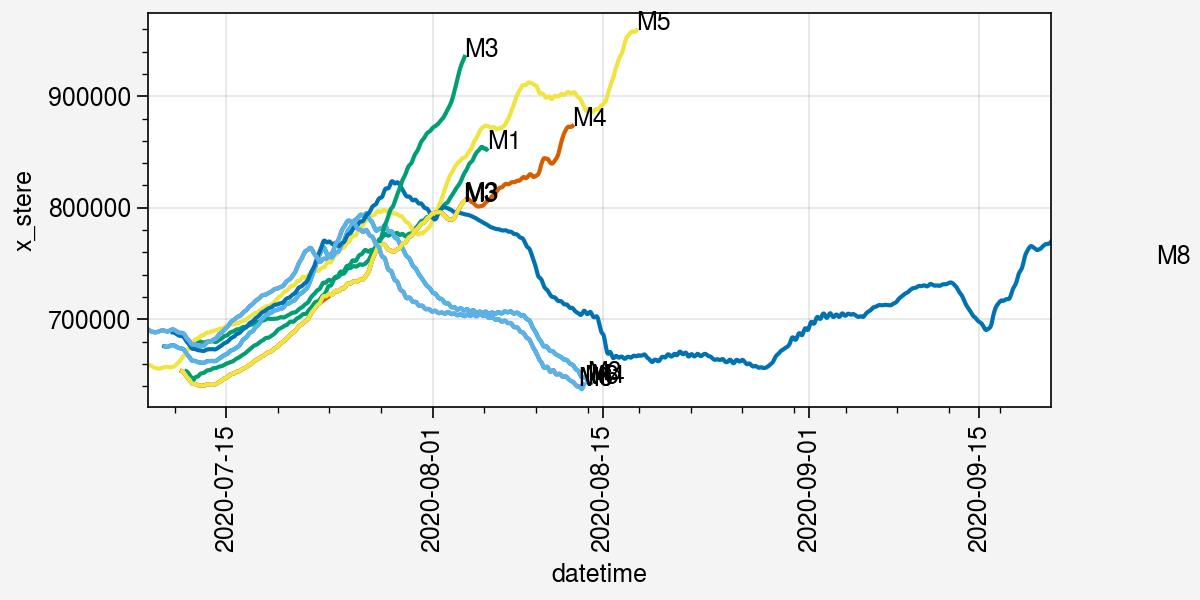

In [47]:
ts = slice('2020-07-01', '2020-09-20')
fig, ax = uplt.subplots(width=6, height=3)
for b in msite_buoys:
    LL = buoy_dfs[b].set_index('datetime').x_stere.copy()
    # LL[LL > 180] = LL[LL > 180] - 360
    ax.plot(LL.loc[ts])
    ax.text(LL.index[-1], LL.values[-1], mosaic_lookup[str(b)][0])

In [48]:
psite_buoys = [int(b) for b in mosaic_lookup if mosaic_lookup[b][0][0] == 'P']
psite_buoys = [b for b in psite_buoys if b in buoy_dfs]
psite_buoys

[300234065981590,
 300234068318250,
 300234010077180,
 300234065090840,
 300234011091780,
 300234068220020,
 300234065980580,
 300234068287880,
 300234011097770,
 300234065984580,
 300234068911790,
 300234065091110,
 300234068225520,
 300234066087220,
 300234068218450,
 300234067700760,
 300234067608220,
 300234067705760,
 300234065985570,
 300234067707750,
 300234068225020,
 300234068129990,
 300234068917830,
 300234010084660,
 300234068281900,
 300234066085220,
 300234068219470,
 300234068123990,
 300234068919740,
 300234068910810,
 300234068916790,
 300234065094850,
 300234066082230,
 300234068911820,
 300234066089220,
 300234064817930,
 300234068215980,
 300234065980590,
 300234010082440,
 300234068910590,
 300234066415350,
 300234068912810,
 300234068916810,
 300234068328160,
 300234066419320,
 300234068222000,
 300234065091830,
 300234010307830,
 300234068280900,
 300234068912800,
 300234068316210,
 300234068283890,
 300234068213470,
 300234067706680]

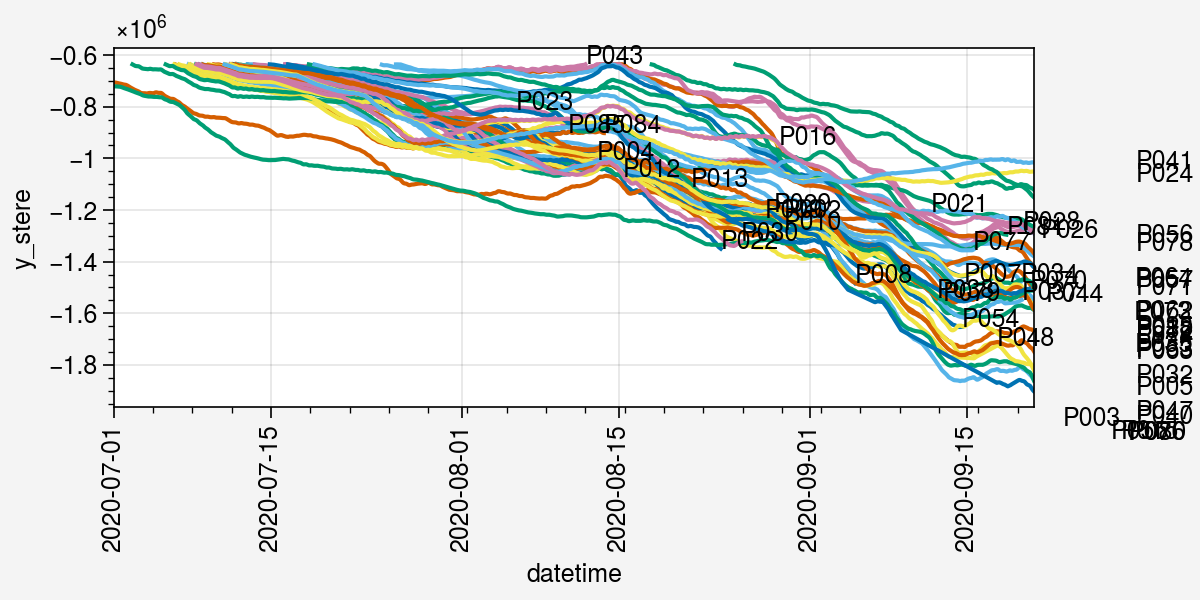

In [49]:
ts = slice('2020-07-01', '2020-09-20')
fig, ax = uplt.subplots(width=6, height=3)
for b in psite_buoys:
    LL = buoy_dfs[b].set_index('datetime').y_stere.copy()
    # LL[LL > 180] = LL[LL > 180] - 360
    ax.plot(LL.loc[ts])
    ax.text(LL.index[-1], LL.values[-1], mosaic_lookup[str(b)][0])

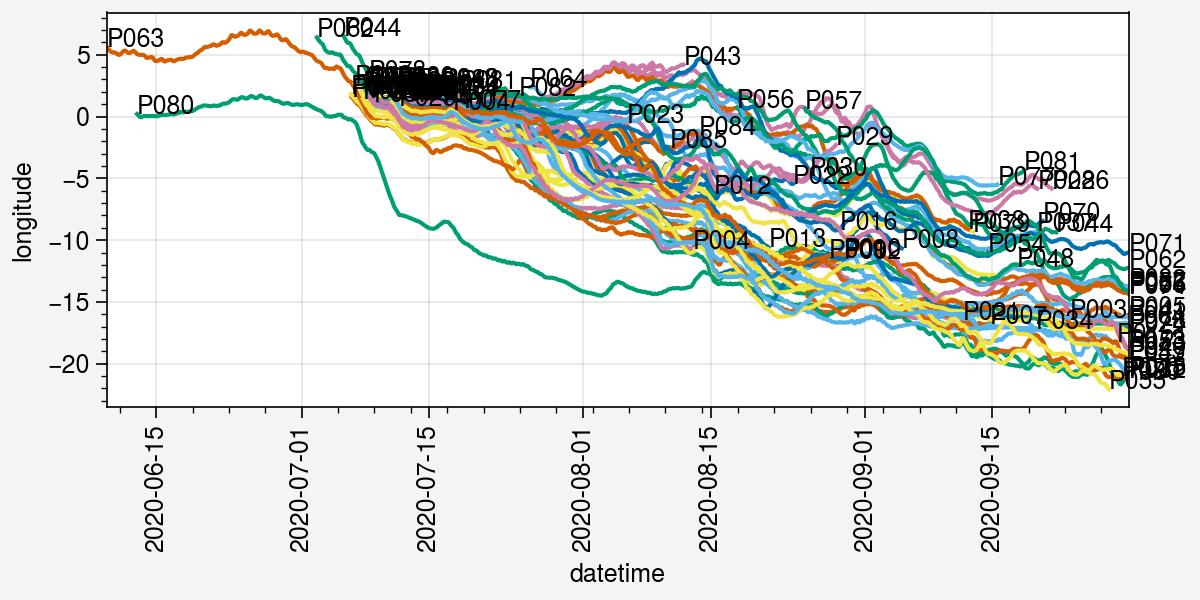

In [50]:
ts = slice('2020-04-01', '2020-09-30')
fig, ax = uplt.subplots(width=6, height=3)
for b in psite_buoys:
    LL = buoy_dfs[b].set_index('datetime').longitude.copy()
    LL[LL > 180] = LL[LL > 180] - 360
    ax.plot(LL.loc[ts])
    ax.text(LL.index[0], LL.values[0], mosaic_lookup[str(b)][0])
    ax.text(LL.index[-1], LL.values[-1], mosaic_lookup[str(b)][0])

In [51]:
remaining = []
for b in psite_buoys:
    if b not in iabp_meta.buoy_id.values:
        remaining.append((b,mosaic_lookup[str(b)][1]))
        print(b, mosaic_lookup[str(b)][0], mosaic_lookup[str(b)][1], buoy_dfs[b].datetime.max())

300234068911790 P010 2019P199 2020-08-29 16:00:10
300234065091110 P034 2019P146 2020-09-19 18:30:00
300234068225520 P085 2020T74 2020-08-10 10:30:14
300234066087220 P047 2019P125 2020-09-30 00:00:00
300234068218450 P056 2019P152 2020-09-30 00:00:00
300234067700760 P043 2019P92 2020-08-12 00:00:54
300234067608220 P048 2019P90 2020-09-17 15:00:26
300234067705760 P037 2019P102 2020-09-19 20:30:26
300234065985570 P022 2019P139 2020-08-24 01:30:00
300234067707750 P038 2019P105 2020-09-12 07:30:32
300234068225020 P012 2019P195 2020-08-15 07:30:44
300234068129990 P028 2019P192 2020-09-19 22:30:25
300234068917830 P016 2019P206 2020-08-29 04:30:25
300234010084660 P082 2020P211 2020-09-30 00:00:00
300234068281900 P071 2020P217 2020-09-29 23:30:24
300234068123990 P029 2019P191 2020-08-28 18:30:26
300234068919740 P009 2019P209 2020-08-28 00:30:26
300234068910810 P018 2019P198 2020-09-29 23:30:25
300234068916790 P002 2019P204 2020-08-29 15:30:28
300234065094850 P035 2019P148 2020-09-29 22:30:00
300

In [52]:
len(remaining)

40

In [59]:
# P-Buoys that drift west into the MIZ
drift_west = [
300234066087220,
300234068919740,
300234068910810,
300234068916790,
300234068911820,
300234066089220,
300234064817930,
300234066415350,
300234068912810,
300234068283890,
300234067706680
]
for b in drift_west:
    print(b, mosaic_lookup[str(b)][0], mosaic_lookup[str(b)][1], buoy_dfs[b].datetime.max())

300234066087220 P047 2019P125 2020-09-30 00:00:00
300234068919740 P009 2019P209 2020-08-28 00:30:26
300234068910810 P018 2019P198 2020-09-29 23:30:25
300234068916790 P002 2019P204 2020-08-29 15:30:28
300234068911820 P004 2019P197 2020-08-13 00:30:39
300234066089220 P040 2019P124 2020-09-30 00:00:00
300234064817930 P064 2019T47 2020-09-29 21:22:52
300234066415350 P076 2020P186 2020-09-29 06:30:16
300234068912810 P007 2019P202 2020-09-14 16:30:34
300234068283890 P073 2020P219 2020-09-29 20:30:26
300234067706680 P041 2019P103 2020-09-29 23:30:25


In [ ]:
# There are an additional 40 buoys in the MOSAiC dataset, however, based on the other P-buoys tested,
# these are unlikely to provide extra dates for comparison.

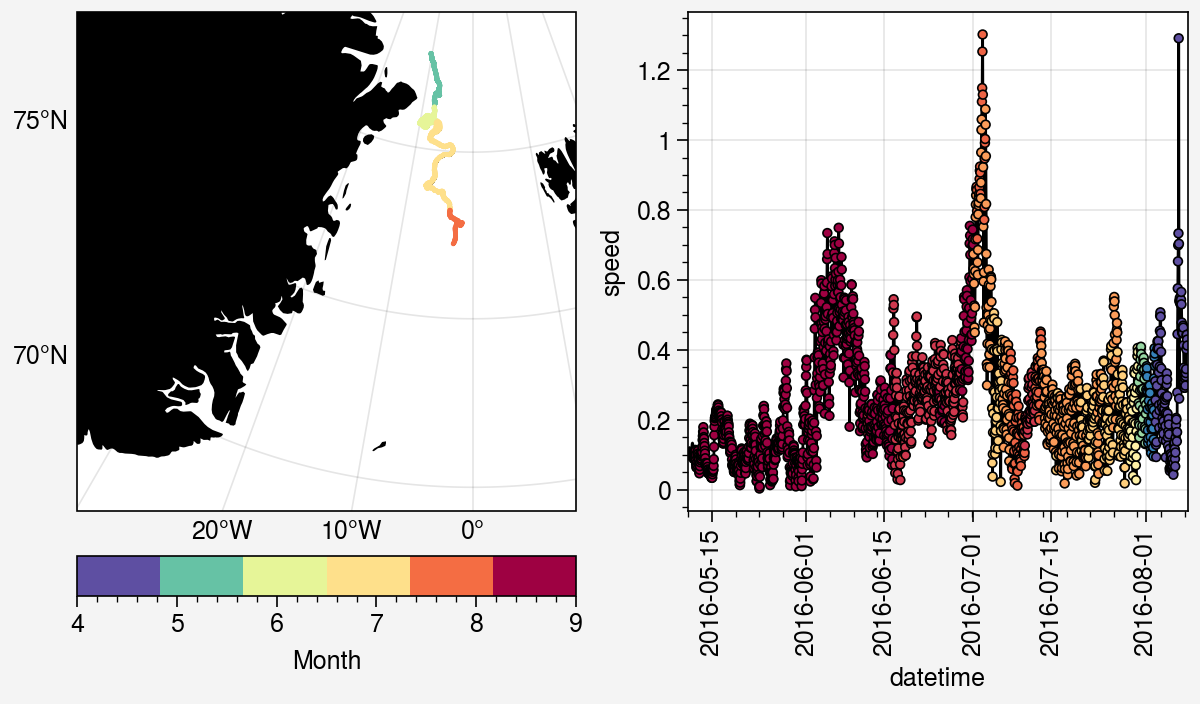

In [156]:
buoy_id = 300234062784540
buoy_df = buoy_dfs[buoy_id]
buoy_df = compute_velocity(buoy_df.set_index('datetime'))

fig, axs = uplt.subplots(width=6, proj=['npstere', None], sharex=False, sharey=False,
                     share=False, ncols=2)
ax = axs[0]
ax.format(land=True,
          lonlocator=np.arange(-100, 30, 10), 
          latmax=85, latlocator=np.arange(55, 85, 5), latlabels=True, lonlabels=True)
ax.set_extent([left, right, bottom, top], crs=crs)  
ax.scatter(buoy_df.longitude, buoy_df.latitude, c='k',  m='.', ms=1, zorder=1)
c = ax.scatter(buoy_df.longitude, buoy_df.latitude, c=buoy_df.index.month, 
       cmap='spectral_r', vmin=4, vmax=9, N=6, marker='.', ms=5, zorder=2)
ax.colorbar(c, loc='b', label='Month')
ax = axs[1]
ax.plot(buoy_df.index, buoy_df.speed, c='k', lw=1, zorder=0)
ax.scatter(buoy_df.index, buoy_df.speed, c=buoy_df.sic_monthly,
          cmap='spectral_r', vmin=0, vmax=1, N=12, marker='o', edgecolor='k', ms=10, zorder=2)

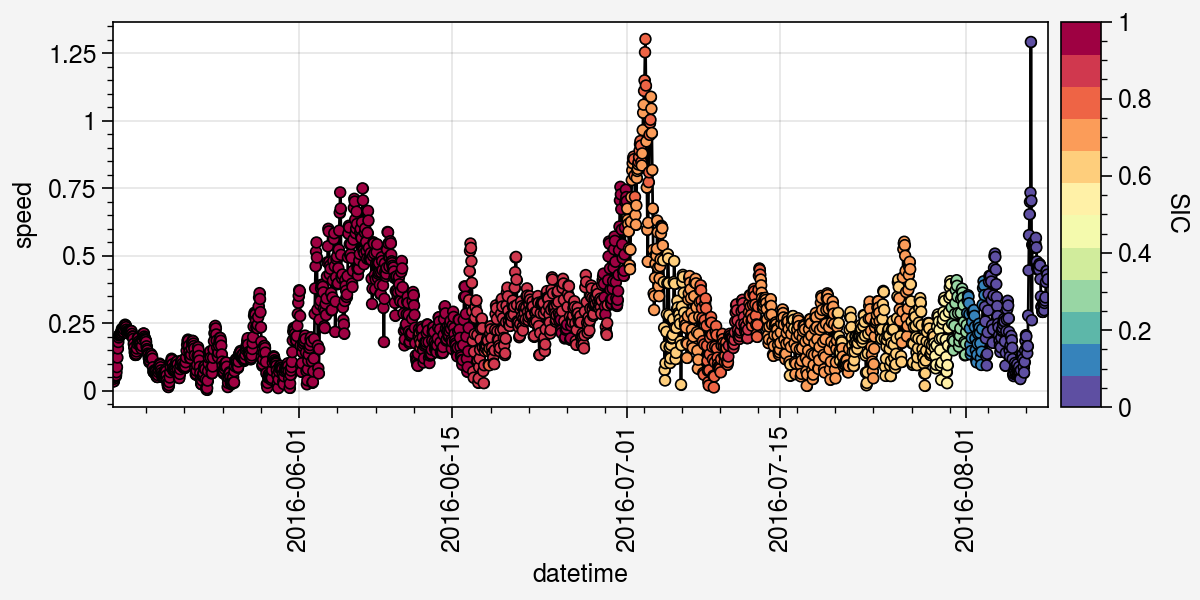

In [159]:
fig, ax = uplt.subplots(width=6, height=3)
t = slice('2016-05-15', '2020-09-30')
ax.plot(buoy_df.loc[t].index, buoy_df.loc[t].speed, c='k', lw=1, zorder=0, marker='.')
c = ax.scatter(buoy_df.loc[t].index, buoy_df.loc[t].speed, c=buoy_df.loc[t].sic_monthly,
          cmap='spectral_r', vmin=0, vmax=1, N=12, marker='o', edgecolor='k', ms=15, zorder=2)
ax.colorbar(c, loc='r', label='SIC')

In [140]:
start_date = buoy_df.index.min().round('1h').strftime('%Y-%m-%d %H:%M')
end_date =  buoy_df.index.max().round('1h').strftime('%Y-%m-%d %H:%M')
# end_date = '2020-09-27 00:00'
end_date

'2020-09-30 00:00'

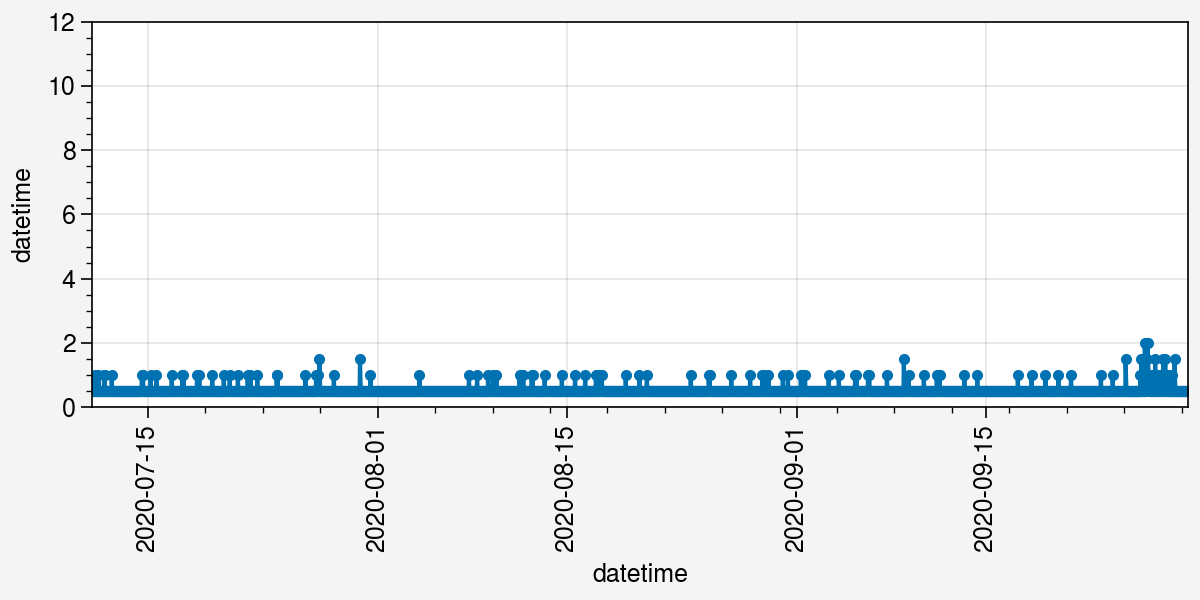

In [141]:
fig, ax = uplt.subplots(width=6, height=3)
ax.plot(buoy_df.index[0:-2], np.round((buoy_df.index[1:-1] - buoy_df.index[0:-2]).total_seconds()/(60*60), 2), marker='.')
ax.format(ylim=(0, 12))

In [142]:
np.median((np.round((buoy_df.index[1:-1] - buoy_df.index[0:-2]).total_seconds()/(60*60), 3)).values)

np.float64(0.5)

In [160]:
dt = '30min'
site_id = mosaic_lookup[str(buoy_id)][0]
', '.join([str(x) for x in [year, buoy_id, dt, start_date, end_date, site_id]])

KeyError: '300234062784540'

In [161]:
# buoy data
columns = ['year', 'buoy_id', 'resolution', 'start_date', 'end_date', 'include']

# Buoys are included in the table if there's a chance of overlap.
# Then, after plotting the maps, I decide whether to use it in the comparison
# based on overlap with the IFT floe data. This choice is based on whether (a) there
# are there more than just a couple time steps that are in the study region (b) there
# are more than a couple time steps that overlap with when we have IFT data and (c) are 
# there enough nearby floes to merit comparison

# check resolution automatically still!
data = [
    [2005, 800003, '3h', '2005-04-01 00:00', '2005-04-28 18:00', True], 
    [2008, 900014, '1h', '2008-04-01 00:00', '2008-09-29 23:00', True],
    [2008, 900017, '1h', '2008-07-15 12:00', '2008-09-27 07:00', False],
    [2010, 900026, '1h', '2010-08-09 07:00', '2010-09-29 23:00', False], # sort of noisy looking. Gets stuck periodically.
    [2010, 900028, '1h', '2010-07-15 00:00', '2010-08-25 10:00', False], # Poor resolution prior to July 15.
    [2010, 900029, '1h', '2010-08-11 17:00', '2010-09-29 22:00', False],
    [2012, 800026, '2h', '2012-09-17 09:00', '2012-09-29 23:00', False],
    [2012, 900056, '1h', '2012-09-17 08:00', '2012-09-29 23:00', False], # Out of monthly SIC range, but likely still sea ice
    [2012, 300025010711490, '1h',  '2012-09-17 08:00', '2012-09-30 00:00', False],
    [2013, 900049, '1h', '2013-04-01 00:00', '2013-06-30 00:00', True], # Truncated when SIC switches to 0
    [2014, 300234011097780, '3h', '2014-05-17 03:00', '2014-08-30 00:00', False], # Likely out of the SIC region by mid August. Needs de-spiking!
    [2014, 300234011884900, '3h', '2014-05-20 15:00', '2014-07-22 00:00', False], # Likely leaves sea ice 7/22
    [2014, 300234061366400, '3h', '2014-08-31 18:00', '2014-09-30 00:00', False],
    [2014, 300234061610020, '1h', '2014-05-20 12:00', '2014-07-20 19:00', False], # Some weird time steps, mostly good
    [2014, 300234061762890, '2h', '2014-07-21 16:00', '2014-08-22 00:00', False], # Leaves ice, becomes erratic
    [2014, 300234061763810, '2h', '2014-08-06 05:00', '2014-09-13 00:00', False], # Bursts of 2h data, then gaps
    [2014, 300234061867100, '2h', '2014-08-06 01:00', '2014-09-21 00:00', False], # Many gaps, truncated when leaves SIC region
    [2015, 137807, '1h', '2015-07-08 07:00', '2015-08-14 19:00', False], # Uneven time spacing. Early part is a mixed ice-water field with clear floes.
    [2015, 137811, '1h', '2015-07-07 00:00', '2015-09-29 23:00', False],
    [2015, 137813, '1h', '2015-04-01 00:00', '2015-06-08 08:00', True],
    [2015, 700009, '1h', '2015-05-05 12:00', '2015-09-29 23:00', True],
    [2015, 900059, '1h', '2015-08-01 00:00', '2015-09-15 23:00', False],
    [2015, 900074, '1h', '2015-05-01 08:00', '2015-05-15 02:00', False],
    [2015, 900075, '1h', '2015-05-29 13:00', '2015-06-08 00:00', False],
    [2015, 300234060890090, '3h', '2015-04-01 00:00', '2015-04-23 21:00', False],
    [2015, 300234060894080, '3h', '2015-04-01 00:00', '2015-08-01 12:00', True],
    [2015, 300234061766880, '2h', '2015-04-01 01:00', '2015-05-11 17:01', True],
    [2015, 300234062424060, '1h', '2015-05-02 11:00', '2015-05-06 21:00', False],
    [2015, 300234062424160, '1h', '2015-09-03 07:30', '2015-09-21 18:30', False],
    [2015, 300234062426060, '1h', '2015-06-01 18:00', '2015-06-11 15:00', False],
    [2015, 300234062426150, '1h', '2015-06-04 05:00', '2015-06-11 13:01', False],
    [2016, 300234062553800, '1h', '2016-04-01 00:00', '2016-06-21 00:00', True], # Buoy drifts into open ocean
    [2016, 300234062784540, '1h', '2016-04-01 00:00', '2016-08-03 00:00', True], # Buoy drifts into open ocean
    [2016, 300234062784540, '1h', '2016-05-10 17:03', '2016-08-02 00:00', True],
    [2017, 132472, '3h', '2017-04-01 00:00', '2017-04-01 00:00', True], # Poor consistency in time resolution
    [2017, 900092, '1h', '2017-06-27 16:00', '2017-07-05 00:00', False],
    [2017, 300025060103020, '1h', '2017-05-26 13:00', '2017-05-26 13:00', True],
    [2017, 300025060205330, '1h', '2017-05-18 13:00', '2017-05-18 13:00', True],
    [2017, 300234060838110, '1h', '2017-05-07 13:00', '2017-05-07 13:00', True], # Will need de-spiking
    [2017, 300234062427070, '2h', '2017-04-27 21:00', '2017-05-22 00:00', True], 
    [2017, 300234063227960, '1h', '2017-04-27 21:00', '2017-05-23 16:00', True],
    [2017, 300234063518440, '3h', '2017-08-24 06:00', '2017-09-29 09:00', False],
    [2017, 300234064010010, '1h', '2017-05-26 13:00', '2017-06-05 03:00', True],
    [2017, 300234064011000, '1h', '2017-05-18 13:00', '2017-05-31 08:00', False],
    [2017, 300234064819860, '2h', '2017-05-18 14:00', '2017-05-31 08:00', False],
    [2017, 300434060175780, '30min', '2017-05-09 14:00', '2017-05-30 00:00', False],
    [2018, 300234010255800, '3h', '2018-05-05 21:00', '2018-09-30 00:00', False],
    [2018, 300234060838110, '1h', '2018-04-02 20:00', '2018-09-30 00:00', True], # Lots of gaps early on
    [2019, 300234064819910, '2h', '2019-04-01 01:00', '2019-05-01 21:00', True],
    [2019, 300234065801040, '1h', '2019-09-07 08:00', '2019-09-30 00:00', True], # Based on worldview images, not likely any overlap
    [2019, 300234066304040, '6h', '2019-04-01 00:00', '2019-08-01 00:00', True],
    [2019, 300234066340550, '1h', '2019-04-01 00:00', '2019-04-09 20:00', False],
    [2019, 300234066341810, '1h', '2019-04-01 00:00', '2019-06-04 03:00', True],    
    [2020, 53093, '1h', '2020-09-10 01:00', '2020-09-29 23:00', False],
    [2020, 900094, '1h', '2020-07-12 09:00', '2020-08-18 08:00', False],
    [2020, 900102, '30min', '2020-07-08 22:00', '2020-08-07 15:00', False],
    [2020, 900111, '30min', '2020-07-12 01:00', '2020-08-06 13:00', False],
    [2020, 900116, '30min', '2020-05-07 03:00', '2020-09-01 00:00', True],
    [2020, 300234062429060, '2h', '2020-04-01 01:00', '2020-05-13 03:00', True],
    [2020, 300234065762510, '2h', '2020-04-01 01:00', '2020-04-21 00:00', False],
    [2020, 300234066342810, '1h', '2020-04-01 00:00', '2020-05-12 13:00', True],
    [2020, 300234066342820, '1h', '2020-04-01 00:00', '2020-07-25 23:00', True], # looks like it'll be super useful!
    [2020, 300234066347840, '1h', '2020-04-01 00:00', '2020-05-27 07:00', True], # only early part is useful.
    [2020, 300234066413390, '1h', '2020-06-01 00:00', '2020-07-01 00:00', False], # likely open water
    [2020, 300234068527600, '30min', '2020-07-11 11:00', '2020-07-31 15:00', False], # MOSAiC Central Observatory
    [2020, 300234066083130, '1h', '2020-07-17 00:00', '2020-08-13 20:00', False], # CO buoy, start comp after MOSAiC floe breakup
    [2020, 300234068210310, '1h', '2020-07-17 00:00', '2020-08-30 00:00', False], # CO buoy, start comp after MOSAiC floe breakup
    [2020, 300234068325170, '30min', '2020-07-17 00:00', '2020-08-07 15:00', False], # CO buoy, start comp after MOSAiC floe breakup
    [2020, 300234062321110, '1h', '2020-07-17 00:00', '2020-08-12 05:00', False], # CO buoy, start comp after MOSAiC floe breakup
    [2020, 300234068706330, '30min', '2020-07-17 00:00', '2020-08-14 09:00', False], # LM buoy. Was on CO floe, so start after breakup. May end up in open water.
    [2020, 300234064233210, '1h', '2020-07-25 10:00', '2020-08-09 12:00', False], # LM buoy. Start when separates from other LM. May end up in open water.
    [2020, 300234066087170, '1h', '2020-07-12 01:00', '2020-08-06 09:00', False], # L1 buoy (snow buoy). Other L1 buoy follows track exactly.
    [2020, 300234068709320, '30min', '2020-07-12 09:00', '2020-08-09 16:00', False], # L2 buoy (T buoy). Other L2 buoy follows track exactly except for last 2 days.]
    [2020, 300234068705280, '2h', '2020-07-08 23:00', '2020-08-07 03:00', False], # L3 buoy (T buoy). Other L3 buoy follows it exactly.
    [2020, 300234068066320, '10min', '2020-07-12 14:00', '2020-08-05 11:00', False], # M1 O-buoy.
    [2020, 300234068164710, '10min', '2020-07-11 08:00', '2020-08-03 13:00', False], # M3 O-buoy. Other M3-labeled buoys follow the M4 labeled buoy.
    [2020, 300234065171790, '2h', '2020-07-11 09:00', '2020-08-12 12:00', False], # M4. T buoy.
    [2020, 300234067066520, '1h', '2020-07-08 14:00', '2020-08-02 00:00', False], #M5. V-buoy -- check datetime to make sure not in Beijing time.
    [2020, 300234068701300, '30min', '2020-07-08 15:00', '2020-08-13 12:00', False], # M6. T buoy.
    [2020, 300234068700320, '1h', '2020-07-10 14:00', '2020-09-29 13:00', False], # M8. T buoy.
    [2020, 300234066085220, '1h', '2020-06-09 13:00', '2020-08-01 00:00', False], # P063/2019P128. Arrives ahead of the MOSAiC array.
    [2020, 300234068219470, '1h', '2020-06-12 21:00', '2020-09-08 00:00', True], #P080/2019P160. Arrives ahead of MOSAiC array.    
    [2020, 300234066082230, '1h', '2020-07-02 16:00', '2020-08-13 00:00', False], #P062 - arrives ahead of MOSAiC array.
    [2020, 300234066419320, '30min', '2020-07-05 15:00', '2020-08-15 00:00', False], #P044 - arrives ahead of MOSAiC array.    
    [2020, 300234065981590, '1hr', '2020-07-12 22:00', '2020-08-29 00:00', False], # 2019P142
    [2020, 300234068318250, '1hr', '2020-07-11 09:00', '2020-09-19 00:00', False], # 2019P151
    [2020, 300234010077180, '1hr', '2020-07-08 08:00', '2020-09-19 00:00', False], # 2019P143
    [2020, 300234065090840, '1.5hr', '2020-07-16 08:00', '2020-08-29 00:00', False], #2019P137
    [2020, 300234011091780, '3hr', '2020-07-07 21:00', '2020-08-01 00:00', False], #2019P215
    [2020, 300234068220020, '30min', '2020-07-12 22:00', '2020-09-01 00:00' , False], #2019P190
    [2020, 300234065980580, '1hr', '2020-07-11 18:00', '2020-08-21 08:00', False], # '2019P138'
    [2020, 300234068287880, '30min', '2020-07-16 10:00', '2020-09-01 00:00', False], #2019P220
    [2020, 300234011097770, '3hr', '2020-07-08 09:00', '2020-09-30 00:00', False], #2020P214
    [2020, 300234065984580, '1hr', '2020-07-08 12:00', '2020-09-11 18:00', False], #2019P140
    [2020, 300234066087220, '1hr', '2020-07-06 12:00', '2020-09-30 00:00', False], # P041
    [2020, 300234068919740, '30min', '2020-07-11 17:00', '2020-08-28 01:00', False], # P009
    [2020, 300234068910810, '30min', '2020-07-07 16:00', '2020-09-30 00:00', False], # P018
    [2020, 300234068916790, '30min', '2020-07-11 17:00', '2020-08-29 16:00', False], # P002
    [2020, 300234068911820, '30min', '2020-07-17 13:00', '2020-08-13 01:00', False], # P004
    [2020, 300234066089220, '1hr', '2020-07-06 20:00', '2020-09-17 00:00', False], # P040
    [2020, 300234064817930, '2hr', '2020-07-26 03:00', '2020-09-17 00:00', False], # P064
    [2020, 300234066415350, '30min', '2020-07-10 23:00', '2020-09-12 00:00', False], # P076
    [2020, 300234068912810, '30min', '2020-07-12 00:00', '2020-09-14 17:00', False], # P007
    [2020, 300234068283890, '30min', '2020-07-08 09:00', '2020-09-27 00:00', False], # P073
    [2020, 300234067706680, '30min', '2020-07-10 21:00', '2020-09-30 00:00', False] #P041
]




iabp_meta = pd.DataFrame(data, columns=columns)
iabp_meta.to_csv("../data/iabp_miz_data/metadata.csv")

In [145]:
iabp_meta.loc[iabp_meta.include]

,year,buoy_id,resolution,start_date,end_date,include
0,2005,800003,3h,2005-04-01 00:00,2005-04-28 18:00,True
1,2008,900014,1h,2008-04-01 00:00,2008-09-29 23:00,True
9,2013,900049,1h,2013-04-01 00:00,2013-06-30 00:00,True
19,2015,137813,1h,2015-04-01 00:00,2015-06-08 08:00,True
20,2015,700009,1h,2015-05-05 12:00,2015-09-29 23:00,True
25,2015,300234060894080,3h,2015-04-01 00:00,2015-08-01 12:00,True
26,2015,300234061766880,2h,2015-04-01 01:00,2015-05-11 17:01,True
31,2016,300234062553800,1h,2016-04-01 00:00,2016-06-21 00:00,True
32,2016,300234062553800,1h,2016-04-01 00:00,2016-08-03 00:00,True
33,2016,300234062784540,1h,2016-05-10 17:03,2016-08-02 00:00,True


In [151]:
buoy_data[2016].buoy_id.unique()

array([300234062553800, 300234062784540])

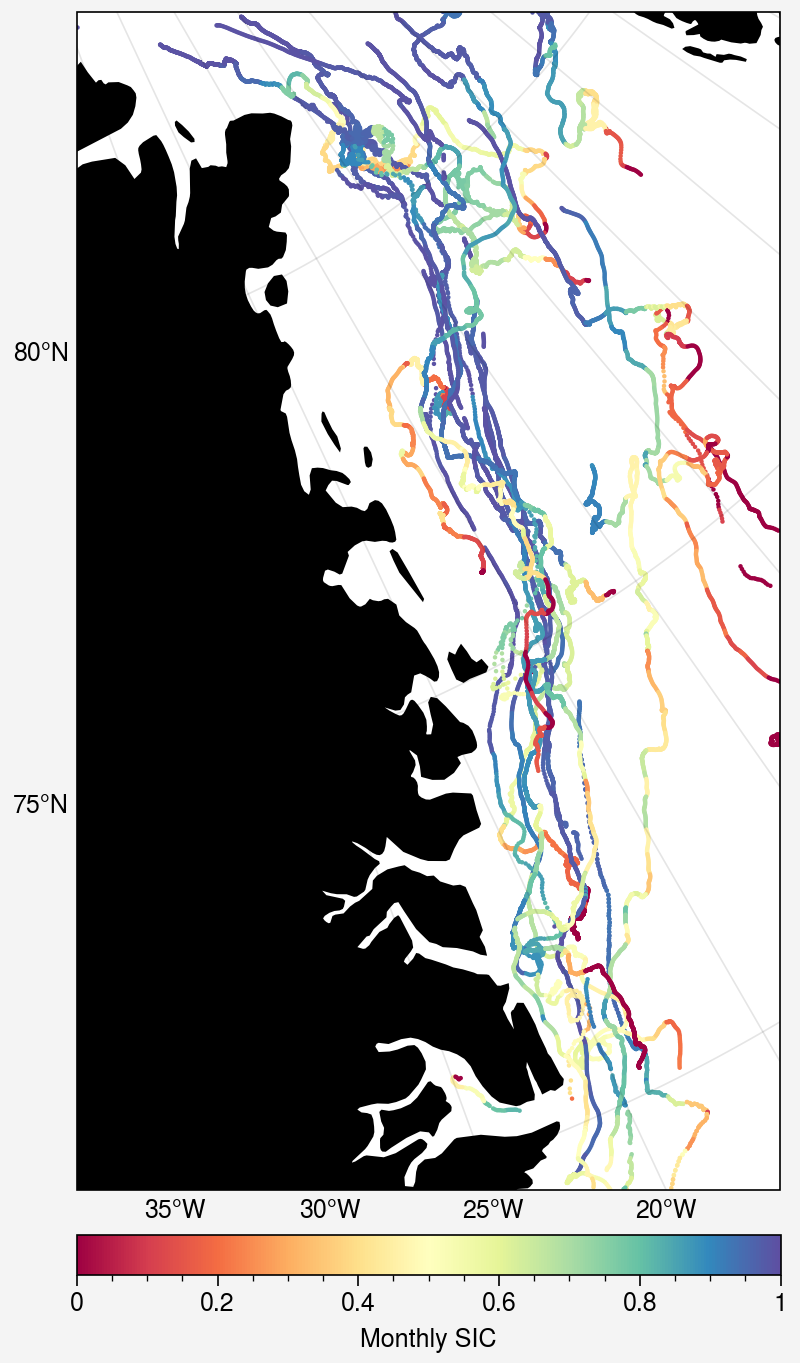

In [176]:

# tbd later: add the sea ice extent, landfast for the start and end of the trajectory
fig, axs = uplt.subplots(width=4, proj='npstere',
                         proj_kw={'lon_0': -45}, share=False)
axs.format(land=True, lonlocator=np.arange(-100, 30, 5), latmax=85, 
           latlocator=np.arange(55, 85, 5), latlabels=True, lonlabels=True)

# IABP buoys
for year, data in iabp_meta.loc[iabp_meta.include, :].groupby('year'):
    buoy_dfs = {buoy_id: group for buoy_id, group in buoy_data[year].groupby('buoy_id')}
    for idx, row_data in data.iterrows():
        
        buoy_df = buoy_dfs[row_data.buoy_id].set_index('datetime')
        t = slice(row_data.start_date, row_data.end_date)
        c = axs.scatter(buoy_df.loc[t, "longitude"],
                buoy_df.loc[t, "latitude"],
                zorder=1, marker='o', label='', ms=1, c=buoy_df.loc[t, "sic_monthly"], vmin=0, vmax=1, 
                   cmap='spectral')
axs.colorbar(c, label='Monthly SIC', loc='b')
axs.set_extent([left, right, bottom, top], crs=crs)  

# Next steps:
- Evaluate start / end points for the buoy time series
- Overlay buoys on IFT data
- Format table of included IABP data and time ranges
- Formalize the intercomparison approach
  * Selecting IFT floe motion vectors within X distance of the buoy
  * Characterize error by difference in drift direction and drift speed magnitude
  * Note examples where it is clear that the buoy is
- Potential for larger set of comparisons with the NSIDC data
  * Ideally I can do the drift anomaly distribution for buoys as well as for the ice floes

# De-spiking
- will need to add the interpolation code, so I can get the positions at the overpass times

# Close examination of buoy tracks
For the Journal of Glaciology paper, we need to see which segments of these trajectories have any IFT trajectories to compare to. It may well be that future versions of the project could have more cases for comparison, for example if any SAR data is used so that smaller floes can be tracked, as well as floes during cloudy days. 

In [146]:
from scipy.interpolate import interp1d

def interpolate_buoy_track_to_reference(buoy_df, new_index, xvar='longitude', yvar='latitude'):
    """Applies interp1d with cubic splines to the pair of variables specied by
    xvar and yvar. Assumes that the dataframe buoy_df has a datetime index.
    Interpolates to new_index where there is overlap.
    """

    t = pd.Series(buoy_df.index)
    dt = pd.to_timedelta(t - t.min()).dt.total_seconds()
    tnew = pd.Series(new_index)
    tnew = tnew[(tnew >= t.min()) & (tnew <= t.max())]    
    dtnew = pd.to_timedelta(tnew - t.min()).dt.total_seconds()
    
    X = buoy_df[[xvar, yvar]].T
    Xnew = interp1d(dt, X.values, bounds_error=False, kind='cubic')(dtnew).T

    df_new = pd.DataFrame(data=np.round(Xnew, 5), 
                          columns=[xvar, yvar],
                          index=tnew)
    df_new.index.names = ['datetime']
    return df_new

In [147]:
import itertools
import numpy as np
import pandas as pd
import ultraplot as pplt
import os
import sys
import warnings

sys.path.append('../scripts/')
from drifter import compute_along_across_components
from scipy.interpolate import interp2d
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter('ignore')

df_ift = pd.read_csv('../data/floe_tracker/ift_floe_trajectories.csv', index_col=0)
df_ift['datetime'] = pd.to_datetime(df_ift['datetime'].values)

# Calculations
# Length scale bins need area adjustment
df_ift['area_adj_km2'] = (np.sqrt(df_ift.area) + 6)**2*.25*.25 # 6 pixel shift minimizes error against manual


For a first comparison, let's look at just the trajectories that are within some buffer region of the buoys.

In [148]:
for idx in iabp_meta.loc[iabp_meta.year >= 2020].index:
    year, buoy_id, res, start_date, end_date, include = iabp_meta.loc[idx, :]
    
    buoy_dfs = {buoy_id: group for buoy_id, group in buoy_data[year].groupby('buoy_id')}
    buoy_df = buoy_dfs[buoy_id]
    buoy_df = buoy_df.loc[buoy_df.datetime.between(start_date, end_date),:]
    
    ift_sel = df_ift.loc[df_ift.datetime.between(start_date, end_date), :]
    if len(ift_sel) > 2:
        ift_sel.dropna()
        
        t = pd.date_range(ift_sel.datetime.min(), ift_sel.datetime.max(), freq='1d')
        buoy_df_daily = interpolate_buoy_track_to_reference(buoy_df.set_index('datetime'), t)
        buoy_df_daily = compute_velocity(buoy_df_daily).dropna()
        
        buffer = 25e3
        ift_sel['close'] = False
        ift_sel['distance'] = np.nan
        for time, data in buoy_df_daily.iterrows():
            d = np.sqrt((ift_sel.x_stere - data.x)**2 + (ift_sel.y_stere - data.y)**2)
            ift_sel.loc[d < buffer, 'close'] = True
            ift_sel.loc[d < buffer, 'distance'] = d[d < buffer]
        
        # tbd later: add the sea ice extent, landfast for the start and end of the trajectory
        fig, axs = uplt.subplots(width=4, proj='npstere',
                                 proj_kw={'lon_0': -45}, share=False)
        axs.format(land=True, lonlocator=np.arange(-100, 30, 10), latmax=85, latlocator=np.arange(55, 85, 5), latlabels=True, lonlabels=True)
        
        axs.plot(buoy_df.longitude, buoy_df.latitude, c='k', lw=2, zorder=1, label='')
        axs.scatter(buoy_df_daily.longitude, buoy_df_daily.latitude, c='b', edgecolor='k',  marker='s', zorder=1, label='')
        axs.scatter(ift_sel.longitude, ift_sel.latitude, marker='o', color='gray', label='Distant floe',
                     ms=15)
        
        ift_nearby = ift_sel.loc[ift_sel.distance < 15e3]
        c = axs.scatter(ift_nearby.longitude, ift_nearby.latitude, marker='o', c=ift_nearby.distance / 1e3, cmap='spectral', 
                    ms=25, edgecolor='k', vmin=0, vmax=25, label='Nearby floe')
        axs.colorbar(c, loc='b', label='Distance to buoy (km)')
        
        axs.quiver(ift_nearby.longitude,
                   ift_nearby.latitude,
                   ift_nearby.u,
                   ift_nearby.v, label='Near-in-space IFT')
        
        axs.quiver(buoy_df_daily.longitude,
                   buoy_df_daily.latitude,
                   buoy_df_daily.u,
                   buoy_df_daily.v, color='blue', label='Buoy')
        
        
        axs.legend(ncols=1)
        crop_left = buoy_df_daily.x.min() - buffer
        crop_right = buoy_df_daily.x.max() + buffer
        crop_bottom = buoy_df_daily.y.min() - buffer
        crop_top = buoy_df_daily.y.max() + buffer
        axs.set_extent([crop_left, crop_right, crop_bottom, crop_top], crs=crs)  
        axs.format(title='Comparison with buoy ' + str(buoy_id) + '\n' + \
                   buoy_df_daily.index.min().strftime("%Y-%m-%d") + '-' + \
                   buoy_df_daily.index.max().strftime("%Y-%m-%d"))
        fig.save('../figures/diagnostics/iabp_map_view/'  + 'buoy_' + str(year) + '_' + str(buoy_id) + '_' + \
                  buoy_df_daily.index.min().strftime("%Y-%m-%d") + '-' + \
                  buoy_df_daily.index.max().strftime("%Y-%m-%d") + \
                 '.png', dpi=300)
        pplt.close(fig)
        
        fig, ax = pplt.subplots(width=12, height=3)
        for f_id, track in ift_sel.groupby('floe_id'):
            ax.plot(track.datetime, track.speed, lw=1, color='red4', zorder=0)
        c = ax.scatter(ift_sel.datetime, ift_sel.speed, c=ift_sel.distance/1e3, cmap='reds_r',  m='o', edgecolor='k')
        ax.plot(buoy_df_daily.index, buoy_df_daily.speed, color='k', m='+', lw=1)
        ax.colorbar(c, loc='r', label='Distance to buoy')
        ax.format(xlabel='', xrotation=45, title='Buoy ' + str(buoy_id), xlim=(buoy_df_daily.index.min(), buoy_df_daily.index.max()))
        fig.save('../figures/diagnostics/iabp_speed_comp/' + 'buoy_' + str(year) + '_' + str(buoy_id) + '_' + \
                  buoy_df_daily.index.min().strftime("%Y-%m-%d") + '-' + \
                  buoy_df_daily.index.max().strftime("%Y-%m-%d") + \
                 '.png', dpi=300)
        pplt.close(fig)

In [386]:
buoy_df_daily.loc['2008-08-18 12:00'].round(3)

longitude        -18.934
latitude          71.912
x             867919.928
y           -1774343.780
u                 -0.031
v                  0.021
speed              0.038
Name: 2008-08-18 12:00:00, dtype: float64

# Cases that will be good for direct comparison with buoy drift
* May 2008, buoy 900014 - Multiple, fairly long periods with clear skies, and close location correspondence with a buoy.
* April-June 2013, buoy 900049
* April 2015 - A few long-traveling buoys that come close to floes
  
## Not as good
2008 900017 - Basically out of the sea ice region by then. No nearby floes.  
2008 900026 - Basically out of the sea ice region by then. No nearby floes.  

Some thoughts on how to analyze this all
- Visualizations. For the best cases, I can zoom in on the region around buoys, and overlay the buoy location +/- 6 hrs from image time on the truecolor image, along with the ice floe shapes.
- Spatial correlations
- Difference in drift speeds as a function of separation distance
- Time correlation, for floes within a certain distance of the buoys

In [1196]:
iabp_meta.head()

,year,buoy_id,resolution,start_date,end_date,include
0,2005,800003,3h,2005-04-01 00:00,2005-04-28 18:00,True
1,2008,900014,1h,2008-04-01 00:00,2008-09-29 23:00,True
2,2008,900017,1h,2008-07-15 12:00,2008-09-27 07:00,False
3,2010,900026,1h,2010-08-09 07:00,2010-09-29 23:00,False
4,2010,900028,1h,2010-07-15 00:00,2010-08-25 10:00,False


# Overlaying buoy data on satellite imagery

In [1]:
import cartopy.crs as ccrs
import numpy as np
import pandas as pd
import pyproj
import rasterio as rio
from rasterio.plot import reshape_as_image
import ultraplot as uplt
import os
import sys
import warnings
import gc


sys.path.append('../scripts/')
from drifter import compute_along_across_components
from scipy.interpolate import interp2d
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter('ignore')


uplt.rc['geo.round'] = False
uplt.rc['reso'] = 'med'

ref_img = rio.open("../data/modis_images/landmask.tiff")
crs0 = pyproj.CRS('WGS84')
crs1 = pyproj.CRS(ref_img.crs)
transformer = pyproj.Transformer.from_crs(crs0, crs_to=crs1, always_xy=True)
left, bottom, right, top = ref_img.bounds

# Tracker data - centered at 12 Z
df_ift = pd.read_csv('../data/floe_tracker/ift_floe_trajectories.csv', index_col=0)
df_ift['datetime'] = pd.to_datetime(df_ift['datetime'].values)
# Length scale bins need area adjustment
df_ift['area_adj_km2'] = (np.sqrt(df_ift.area) + 6)**2*.25*.25 # 6 pixel shift minimizes error against manual


iabp_meta = pd.read_csv('../data/iabp_miz_data/metadata.csv', index_col=0)

In [2]:
# Floe positions at original resolution
floe_lib_clean = {}
for file in os.listdir('../data/floe_tracker/ift_floe_property_tables/clean/'):
    if 'csv' in file: 
        year = int(file.replace('.csv', '').split('_')[-1])
        floe_lib_clean[year] = pd.read_csv('../data/floe_tracker/ift_floe_property_tables/clean/' + file,
                                         index_col=0, dtype={'classification': str})
        floe_lib_clean[year]['datetime'] = pd.to_datetime(floe_lib_clean[year]['datetime'])
floe_lib_clean = pd.concat(floe_lib_clean).reset_index()

In [3]:
data_loc = '../data/iabp_miz_data/'
buoy_data = {}
for year in range(2003, 2021):
    df = pd.read_csv(data_loc + 'iabp_data_{y}.csv'.format(y=year),
                     index_col=0, parse_dates=['datetime'])
    df['x_stere'], df['y_stere'] = transformer.transform(df.longitude, df.latitude)
    start_date = pd.to_datetime('{y}-04-01'.format(y=year))
    end_date = pd.to_datetime('{y}-09-30'.format(y=year))
    in_scene = df.x_stere.between(left, right) & df.y_stere.between(bottom, top)
    in_timerange = df.datetime.between(start_date, end_date)
    sel_idx = in_scene & in_timerange
    df_counts = df.loc[sel_idx].groupby('buoy_id').count()
    if len(df_counts) > 0:
        if len(df.loc[sel_idx]) > 100:
            buoy_data[year] = df.loc[in_scene & in_timerange].copy()

In [11]:
iabp_meta.loc[(iabp_meta.year == 2019) & (iabp_meta.include)]

,year,buoy_id,resolution,start_date,end_date,include
48,2019,300234064819910,2h,2019-04-01 01:00,2019-05-01 21:00,True
49,2019,300234065801040,1h,2019-09-07 08:00,2019-09-30 00:00,True
50,2019,300234066304040,6h,2019-04-01 00:00,2019-08-01 00:00,True
52,2019,300234066341810,1h,2019-04-01 00:00,2019-06-04 03:00,True


In [10]:
dataloc = "/Volumes/Research/ENG_Wilhelmus_Shared/group/IFT_fram_strait_dataset/"

tc_images = {}
matlab_floe_images = {}
clean_floe_images = {}

def get_month_folder(date):
    """Simple utility for navigating file structure"""
    start = '{y}{m}01'.format(y=date.year,
                              m=str(date.month).zfill(2))
    end = '{y}{m}01'.format(y=date.year,
                              m=str(date.month + 1).zfill(2))
    if (date.month == 3) | (date.month == 4):
        start = '{y}0331'.format(y=date.year)
        end = '{y}0501'.format(y=date.year)
    
    return '-'.join(['fram_strait', start, end])

start_date = '2019-06-01'
end_date = '2019-07-01'

for date in pd.date_range(start_date, end_date, freq='1d'):
    satellite = 'aqua'
    if date not in tc_images:
        tc_images[date] = rio.open(dataloc + 'fram_strait-{y}/{m}/truecolor/{d}.{s}.truecolor.250m.tiff'.format(
            d=date.strftime('%Y%m%d'), s=satellite, y=date.year, m=get_month_folder(date))).read()
        matlab_floe_images[date] = rio.open(dataloc + 'fram_strait-{y}/{m}/labeled_raw/{d}.{s}.labeled_raw.250m.tiff'.format(
            d=date.strftime('%Y%m%d'), s=satellite, y=date.year, m=get_month_folder(date))).read()
        clean_floe_images[date] = rio.open(dataloc + 'fram_strait-{y}/{m}/labeled_clean/{d}.{s}.labeled_clean.250m.tiff'.format(
            d=date.strftime('%Y%m%d'), s=satellite, y=date.year, m=get_month_folder(date))).read()

ref = rio.open(dataloc + 'fram_strait-{y}/{m}/landmask.tiff'.format(
        d=date.strftime('%Y%m%d'), s=satellite, y=date.year, m=get_month_folder(date)))
lm = ref.read()

In [12]:
gc.collect()

1132

In [14]:
iabp_meta.loc[(iabp_meta.year == 2019) & (iabp_meta.include)]

,year,buoy_id,resolution,start_date,end_date,include
48,2019,300234064819910,2h,2019-04-01 01:00,2019-05-01 21:00,True
49,2019,300234065801040,1h,2019-09-07 08:00,2019-09-30 00:00,True
50,2019,300234066304040,6h,2019-04-01 00:00,2019-08-01 00:00,True
52,2019,300234066341810,1h,2019-04-01 00:00,2019-06-04 03:00,True


In [16]:
# Overlaying buoy data on satellite imagery
# for 2020, I've done the month of April for idx's 58, 59, 60, 61, 62.
# Next up: May. #59 doesn't have any May data.
# 58 finishes May 13
# 60 finishes May 12
# 62 finishes May 27
# 61 goes longest, it goes until July 25th.

# For 2019:
idx = 50
year, buoy_id, res, start_date, end_date, include = iabp_meta.loc[idx, :]
buoy_dfs = {buoy_id: group for buoy_id, group in buoy_data[year].groupby('buoy_id')}
buoy_df = buoy_dfs[buoy_id]
buoy_df = buoy_df.loc[buoy_df.datetime.between(start_date, end_date),:]
ift_sel = df_ift.loc[df_ift.datetime.between(start_date, end_date), :]
print(start_date, end_date)

2019-04-01 00:00 2019-08-01 00:00


I've loaded satellite images for each day, just for the Aqua satellite. I'll need to get more exact times, however for now, I'll go with a fixed time range and plot the buoy data at full time resolution. 

For the 2020 buoys that I'm running (the ones starting in April), I've just got to do the one that keeps going in June-July.

In [21]:

os.makedirs('../figures/diagnostics/tc_overlays/{b}'.format(b=buoy_id), exist_ok=True)

# for date in pd.date_range(start_date, end_date, freq='1d'):
for date in pd.date_range('2019-06-18', '2019-06-30', freq='1d'):
    dt = pd.to_timedelta('4h')
    buoy_sel = buoy_df.loc[buoy_df.datetime.between(date - dt, date + dt), :]
    if len(buoy_sel) > 0:
        dx = 100e3 # 200 km window
        x0 = buoy_sel.x_stere.mean()
        y0 = buoy_sel.y_stere.mean()
        if date in tc_images:
            fig, ax = uplt.subplots(width=5)
            
            tc = reshape_as_image(tc_images[date])
            floes_raw = matlab_floe_images[date].squeeze()
            floes_clean = clean_floe_images[date].squeeze()
            
            color_raw = '#ffa867ff' #orange
            color_clean = '#519cccff' #blue
            
            ax.imshow(tc, extent=[left, right, bottom, top])
            ax.imshow(np.ma.masked_array(floes_raw, (floes_raw==0) | (floes_clean > 0)), color=color_raw, alpha=0.5, extent=[left, right, bottom, top])
            ax.imshow(np.ma.masked_array(floes_clean, floes_clean==0), color=color_clean, alpha=0.5, extent=[left, right, bottom, top])
            ax.plot(buoy_sel.x_stere, buoy_sel.y_stere, marker='.', color='b')
            lon0 = buoy_sel.longitude.mean()
            lat0 = buoy_sel.latitude.mean()
            ax.format(grid=False, xticks=False, yticks=False,
                      ltitle=date.strftime('%Y-%m-%d'), yreverse=True, xreverse=False, xlabel='', ylabel='',
                      rtitle='Loc: {a}$^\circ$ N, {b}$^\circ$ E'.format(a=np.round(lat0, 2), b=np.round(lon0, 2)),
                      xlim=(x0 - dx, x0 + dx), ylim=(y0 - dx, y0 + dx))
        
            fname = '../figures/diagnostics/tc_overlays/{b}/{b}_{d}.png'.format(b=buoy_id, d=date.strftime('%Y-%m-%d'))
            fig.save(fname, dpi=300)
            uplt.close(fig)
        
            # Images build up in RAM even though the figure was closed
            gc.collect()

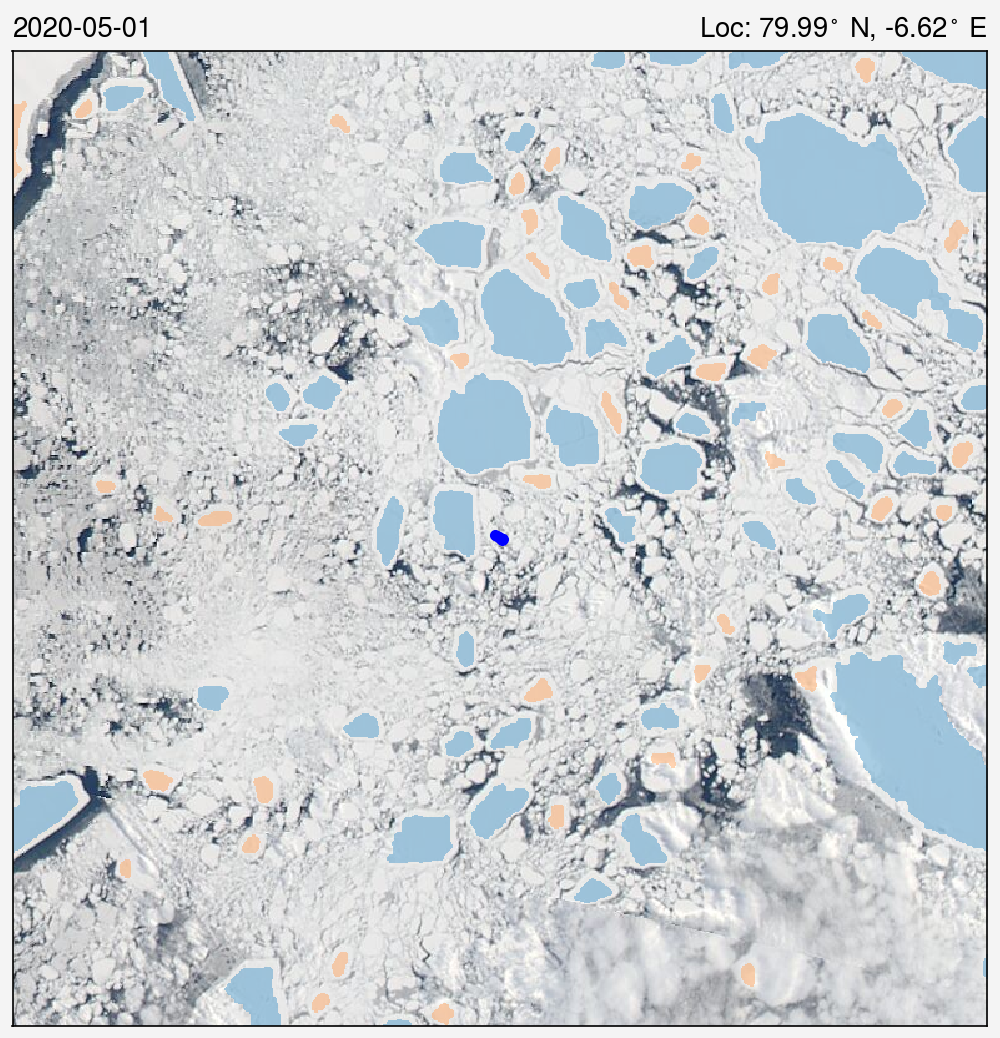

In [69]:
fig, ax = uplt.subplots(width=5)

tc = reshape_as_image(tc_images[date])
floes_raw = matlab_floe_images[date].squeeze()
floes_clean = clean_floe_images[date].squeeze()

color_raw = '#ffa867ff' #orange
color_clean = '#519cccff' #blue

ax.imshow(tc, extent=[left, right, bottom, top])
ax.imshow(np.ma.masked_array(floes_raw, (floes_raw==0) | (floes_clean > 0)), color=color_raw, alpha=0.5, extent=[left, right, bottom, top])
ax.imshow(np.ma.masked_array(floes_clean, floes_clean==0), color=color_clean, alpha=0.5, extent=[left, right, bottom, top])
ax.plot(buoy_sel.x_stere, buoy_sel.y_stere, marker='.', color='b')
lon0 = buoy_sel.longitude.mean()
lat0 = buoy_sel.latitude.mean()
ax.format(grid=False, xticks=False, yticks=False,
          ltitle=date.strftime('%Y-%m-%d'), yreverse=True, xreverse=False, xlabel='', ylabel='',
          rtitle='Loc: {a}$^\circ$ N, {b}$^\circ$ E'.format(a=np.round(lat0, 2), b=np.round(lon0, 2)),
          xlim=(x0 - dx, x0 + dx), ylim=(y0 - dx, y0 + dx))

# Results
| Year | Buoy | Notes |
|---|---|---|
| 2005 | 800003 | The buoy is right next to a tracked floe. This will be a good case for testing the tracker. Lots of good floes with a few poorly segmented objects which are potentially fixable with post-processing.|
| 2008 | 900014 | The buoy leaves the sea ice by July 22. Prior, it doesn't exactly align with a floe, but is amongst many well -identified floes. So for spring, at least, it's a good candidate for validation. |
| 2008 | 900017 | The buoy starts out in the sea ice filaments at the edge of the MIZ. Not useful for validation. |
| 2010 | 900026 | The buoy has a few floes nearby, only for the first few days. |
| 2010 | 900028 | Also a few floes nearby, mostly not detected though. Clearly melting away. |
| 2010 | 900029 | Images are plotting upside down, which is weird. Pack ice north of Greenland, not much use for validation since there are so many clouds.|

1037283